In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
from dateutil import parser, relativedelta
import math
import scipy.signal as ss
from apexpy import Apex
import igrf
from pysolar.solar import *
import scipy.io as io
from scipy import interpolate

In [2]:
on2_mlt=np.load('td_rebin_mlt.npy', allow_pickle=True)
on2_mlon=np.load('td_rebin_mlon.npy', allow_pickle=True)

In [3]:
on2_mlt.shape

(180, 120)

In [4]:
l=on2_mlt[90,60]

In [5]:
x=[]
y=[]
for i in range(len(l)):
    x.append(l[i][0])
    y.append(l[i][1])

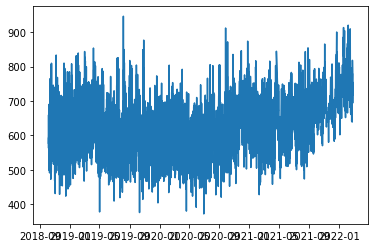

In [6]:
plt.plot(x,y)

In [7]:
print(min(x),max(x))

2018-10-05 11:40:31 2022-02-27 16:22:27


In [8]:
base = datetime.datetime(2018,10,15)
date_list = [base + relativedelta.relativedelta(days=7*x) for x in range(55)]

In [9]:
date_list=np.array(date_list)

In [10]:
date_list

array([datetime.datetime(2018, 10, 15, 0, 0),
       datetime.datetime(2018, 10, 22, 0, 0),
       datetime.datetime(2018, 10, 29, 0, 0),
       datetime.datetime(2018, 11, 5, 0, 0),
       datetime.datetime(2018, 11, 12, 0, 0),
       datetime.datetime(2018, 11, 19, 0, 0),
       datetime.datetime(2018, 11, 26, 0, 0),
       datetime.datetime(2018, 12, 3, 0, 0),
       datetime.datetime(2018, 12, 10, 0, 0),
       datetime.datetime(2018, 12, 17, 0, 0),
       datetime.datetime(2018, 12, 24, 0, 0),
       datetime.datetime(2018, 12, 31, 0, 0),
       datetime.datetime(2019, 1, 7, 0, 0),
       datetime.datetime(2019, 1, 14, 0, 0),
       datetime.datetime(2019, 1, 21, 0, 0),
       datetime.datetime(2019, 1, 28, 0, 0),
       datetime.datetime(2019, 2, 4, 0, 0),
       datetime.datetime(2019, 2, 11, 0, 0),
       datetime.datetime(2019, 2, 18, 0, 0),
       datetime.datetime(2019, 2, 25, 0, 0),
       datetime.datetime(2019, 3, 4, 0, 0),
       datetime.datetime(2019, 3, 11, 0, 0),
   

# Monthly-average Global O/N2 

In [11]:
on2_mlt_month=np.empty((len(date_list), 60, 120),dtype=object)
on2_mlt_month_dt=np.empty((len(date_list), 60, 120),dtype=object)

for i in range(len(date_list)):
    for j in range(60):
        for k in range(120):
            on2_mlt_month[i,j,k]=[]
            on2_mlt_month_dt[i,j,k]=[]

In [12]:
for j in range(60):
    for k in range(120):
        for c in range(3):
            l=on2_mlt[3*j+c,k]
            for t in range(len(l)):
                dtime=l[t][0]
                if dtime>date_list[-1]: break
                a=[abs((dtime-date_list)[i].days) for i in range(len(date_list))]
                on2_mlt_month[np.argmin(a),j,k].append(l[t][1])
                on2_mlt_month_dt[np.argmin(a),j,k].append(l[t][0])

In [13]:
on2_mlt_month_ave=np.empty((len(date_list), 60, 120))
on2_mlt_month_std=np.empty((len(date_list), 60, 120))
on2_mlt_month_cnt=np.empty((len(date_list), 60, 120))
for i in range(len(date_list)):
    for j in range(60):
        for k in range(120):
            if len(on2_mlt_month[i,j,k])==0:
                on2_mlt_month_ave[i,j,k]=np.nan
                on2_mlt_month_std[i,j,k]=np.nan
                on2_mlt_month_cnt[i,j,k]=0
            else:
                on2_mlt_month_ave[i,j,k]=np.mean(on2_mlt_month[i,j,k])
                on2_mlt_month_std[i,j,k]=np.std(on2_mlt_month[i,j,k])
                on2_mlt_month_cnt[i,j,k]=len(on2_mlt_month[i,j,k])

# Monthly-average Global Delta O/N2 

In [14]:
delta=np.zeros((len(date_list), 30, 120))

for i in range(len(date_list)):
    for j in range(30):
        for k in range(120):
            s=on2_mlt_month_ave[i,59-j,k]+on2_mlt_month_ave[i,j,k]
            diff=on2_mlt_month_ave[i,59-j,k]-on2_mlt_month_ave[i,j,k]
            delta[i,29-j,k]=2*diff/s

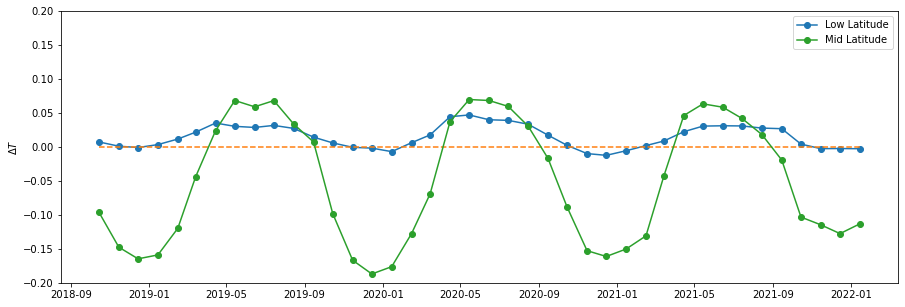

In [46]:
plt.figure(figsize=(15,5))

g=[]
for i in range(len(date_list)):
    g.append(np.nanmean(delta[i,:7,:]))
plt.plot(date_list, g, 'o-', label='Low Latitude')
plt.plot([date_list[0], date_list[-1]], [0,0], '--')

g=[]
for i in range(len(date_list)):
    g.append(np.nanmean(delta[i,7:,:]))
plt.plot(date_list, g, 'o-', label='Mid Latitude')
plt.ylabel('$\Delta T$')
plt.ylim([-0.2, 0.2])
plt.legend()

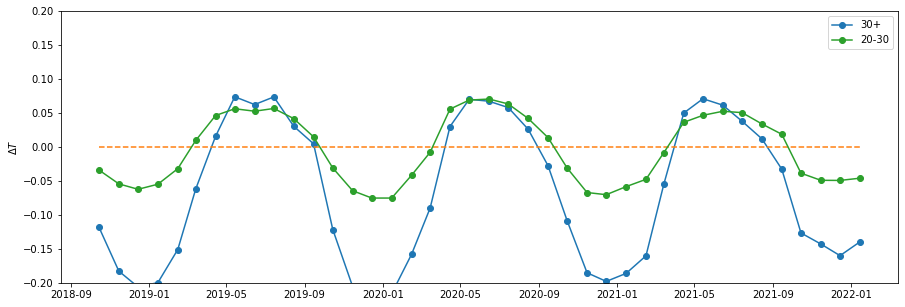

In [17]:
plt.figure(figsize=(15,5))

g=[]
for i in range(len(date_list)):
     g.append(np.nanmean(delta[i,10:,:]))
plt.plot(date_list, g, 'o-', label='30+')
plt.plot([date_list[0], date_list[-1]], [0,0], '--')

g=[]
for i in range(len(date_list)):
    g.append(np.nanmean(delta[i,7:10,:]))
plt.plot(date_list, g, 'o-', label='20-30')
plt.ylabel('$\Delta T$')
plt.ylim([-0.2, 0.2])
plt.legend()

In [18]:
import pickle 
with open("index_on2", "rb") as fp:   # Unpickling
    g2 = pickle.load(fp)

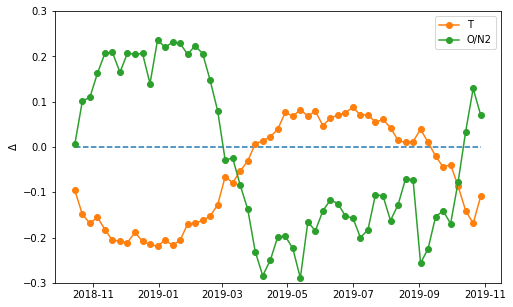

In [23]:
plt.figure(figsize=(8,5))

# g=[]
# for i in range(len(date_list)):
#     g.append(np.nanmean(delta[i,:7,:]))
# plt.plot(date_list, g, 'o-', label='Low Latitude')
plt.plot([date_list[0], date_list[-1]], [0,0], '--')

g=[]
for i in range(len(date_list)):
    g.append(np.nanmean(delta[i,10:,:]))
plt.plot(date_list, g, 'o-', label='T')

plt.plot(date_list, g2, 'o-', label='O/N2')
plt.ylabel('$\Delta$')
plt.ylim([-0.3, 0.3])
plt.legend()

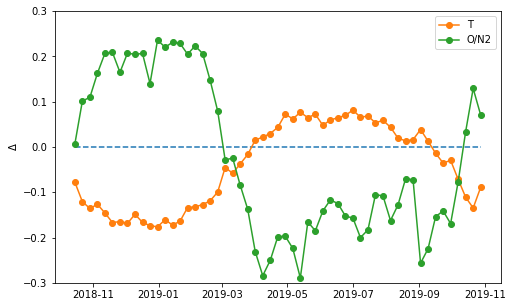

In [24]:
plt.figure(figsize=(8,5))

# g=[]
# for i in range(len(date_list)):
#     g.append(np.nanmean(delta[i,:7,:]))
# plt.plot(date_list, g, 'o-', label='Low Latitude')
plt.plot([date_list[0], date_list[-1]], [0,0], '--')

g=[]
for i in range(len(date_list)):
    g.append(np.nanmean(delta[i,7:,:]))
plt.plot(date_list, g, 'o-', label='T')

plt.plot(date_list, g2, 'o-', label='O/N2')
plt.ylabel('$\Delta$')
plt.ylim([-0.3, 0.3])
plt.legend()